In [1]:
from featexp import get_trend_stats
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

In [2]:
def print_f_imp(clf,n_top=10):
    feat_imp = pd.DataFrame({'importance':clf.feature_importances_})    
    feat_imp['feature'] = data_train.columns
    feat_imp.sort_values(by='importance', ascending=False, inplace=True)
    feat_imp_r = feat_imp
    feat_imp = feat_imp.iloc[:n_top]

    feat_imp.sort_values(by='importance', inplace=True)
    feat_imp = feat_imp.set_index('feature', drop=True)
    feat_imp.plot.barh(figsize=(8,8))
    
    plt.xlabel('Feature Importance Score')
    plt.show()
    return  feat_imp_r

In [3]:
import time
iss = 0

def make_submit(pred):
    global iss
    submit = pd.DataFrame()
    submit['id'] = data_test['id']
    submit['skilled'] = pred
    iss += 1
    submit.to_csv('submissions/submission{}-{}.csv'.format(''.join(time.ctime().split()[2]), i), index=False)
    print('last: ', 'submissions/submission{}-{}.csv'.format(''.join(time.ctime().split()[2]), i))

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
import sklearn 
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import catboost
import lightgbm
import xgboost
import eli5
from eli5.sklearn import PermutationImportance

In [2]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier, Ridge
from sklearn.model_selection import ShuffleSplit, KFold, StratifiedKFold, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import roc_auc_score

TODO: 
------
 + avg freatures, teammates, series 
 + add all features 
 + stecking, boosting, knn 

Liderboard
--------

+ v1 - 0.77853(xgb)- 0.77439(cat), local cv array([0.7779224 , 0.78126565, 0.77225393, 0.78291779, 0.78121558]) - можно докрутить до 0.78<br>
+ v2 - 0.77897
+ v3 - 0.77915
+ v4 - 0.79367, local 0.793555
+ v5_3 - __0.81329__ , local 0.811123247769889
+ v6 - __	0.813937__, local 0.81109290
+ v6_1 - __0.81426__, local 0.813671946113235

<hr>

In [3]:
data_train = pd.read_csv('data/data_train_v6_1.csv')
data_test = pd.read_csv('data/data_test_v6_1.csv')
target = data_train.skilled

In [4]:
data_train['gold/gold_spent'] = (data_train['gold'] + 0.01) / (data_train['gold_spent'] + 0.01)
data_train['gold_spent/goldpermin'] = (data_train['gold_spent'] + 0.01) / (data_train['gold_per_min'] + 0.01)
data_train['gold_spent/net_worth'] = (data_train['gold_spent'] + 0.01) / (data_train['net_worth'] + 0.01)
data_train['is_player_team_win'] = (data_train['player_team'] == data_train['winner_team']).astype('int')
data_train['duration*gpm'] = (data_train['duration'] / 60) * data_train['gold_per_min']
data_train['duration*xpm'] = (data_train['duration'] / 60) * data_train['xp_per_min']
data_train['armor'] = data_train['base_armor'] + data_train['level'] * data_train['agi_gain'] / 6 
data_train['rate_range_attack'] = data_train['attack_range'] * data_train['attack_rate']

for i in ['skilled','gold_per_min','xp_per_min', 'avg_kills_x16','avg_deaths_x16','avg_assists_x16','avg_gpm_x16','avg_xpm_x16','best_kills_x16','best_assists_x16','best_gpm_x16','best_xpm_x16','win_streak','best_win_streak']:
    mn_1 = data_train.groupby('hero_id')[i].mean()
    data_train['gp_h{}_mean'.format(i)] = data_train['hero_id'].map(mn_1)
    
for i in ['gold_per_min','xp_per_min','avg_kills_x16','avg_deaths_x16','avg_assists_x16','avg_gpm_x16','avg_xpm_x16','best_kills_x16','best_assists_x16','best_gpm_x16','best_xpm_x16','win_streak','best_win_streak']:
    mn_1 =data_train.groupby('hero_id')[i].median()
    data_train['gp_h{}_median'.format(i)] = data_train['hero_id'].map(mn_1)
    
for i in ['gold_per_min','xp_per_min','avg_kills_x16','avg_deaths_x16','avg_assists_x16','avg_gpm_x16','avg_xpm_x16','best_kills_x16','best_assists_x16','best_gpm_x16','best_xpm_x16','win_streak','best_win_streak']:
    mn_1 =data_train.groupby('hero_id')[i].max()
    data_train['gp_h{}_max'.format(i)] = data_train['hero_id'].map(mn_1)
    
for i in ['gold_per_min','xp_per_min','avg_kills_x16','avg_deaths_x16','avg_assists_x16','avg_gpm_x16','avg_xpm_x16','best_kills_x16','best_assists_x16','best_gpm_x16','best_xpm_x16','win_streak','best_win_streak']:
    data_train['delta_{}_mean'.format(i)] = data_train['gp_h{}_mean'.format(i)] - data_train[i]
    
for i in ['gold_per_min','xp_per_min', 'avg_kills_x16','avg_deaths_x16','avg_assists_x16','avg_gpm_x16','avg_xpm_x16','best_kills_x16','best_assists_x16','best_gpm_x16','best_xpm_x16','win_streak','best_win_streak']:
    data_train['delta_{}_max'.format(i)] = data_train['gp_h{}_max'.format(i)] - data_train[i]

for i in ['gold_per_min','xp_per_min','avg_kills_x16','avg_deaths_x16','avg_assists_x16','avg_gpm_x16','avg_xpm_x16','best_kills_x16','best_assists_x16','best_gpm_x16','best_xpm_x16','win_streak','best_win_streak']:
    data_train['delta_{}_median'.format(i)] = data_train['gp_h{}_median'.format(i)] - data_train[i]

In [5]:
data_test['gold/gold_spent'] = (data_test['gold'] + 0.01) / (data_test['gold_spent'] + 0.01)
data_test['gold_spent/goldpermin'] = (data_test['gold_spent'] + 0.01) / (data_test['gold_per_min'] + 0.01)
data_test['gold_spent/net_worth'] = (data_test['gold_spent'] + 0.01) / (data_test['net_worth'] + 0.01)
data_test['is_player_team_win'] = (data_test['player_team'] == data_test['winner_team']).astype('int')
data_test['duration*gpm'] = (data_test['duration'] / 60) * data_test['gold_per_min']
data_test['duration*xpm'] = (data_test['duration'] / 60) * data_test['xp_per_min']
data_test['armor'] = data_test['base_armor'] + data_test['level'] * data_test['agi_gain'] / 6 
data_test['rate_range_attack'] = data_test['attack_range'] * data_test['attack_rate']

mn_1 =data_train.groupby('hero_id')['skilled'].mean()
data_test['gp_hskilled_mean'] = data_test['hero_id'].map(mn_1)

for i in ['gold_per_min','xp_per_min', 'avg_kills_x16','avg_deaths_x16','avg_assists_x16','avg_gpm_x16','avg_xpm_x16','best_kills_x16','best_assists_x16','best_gpm_x16','best_xpm_x16','win_streak','best_win_streak']:
    mn_1 =data_test.groupby('hero_id')[i].mean()
    data_test['gp_h{}_mean'.format(i)] = data_test['hero_id'].map(mn_1)
    
for i in ['gold_per_min','xp_per_min','avg_kills_x16','avg_deaths_x16','avg_assists_x16','avg_gpm_x16','avg_xpm_x16','best_kills_x16','best_assists_x16','best_gpm_x16','best_xpm_x16','win_streak','best_win_streak']:
    mn_1 =data_test.groupby('hero_id')[i].median()
    data_test['gp_h{}_median'.format(i)] = data_test['hero_id'].map(mn_1)
    
for i in ['gold_per_min','xp_per_min','avg_kills_x16','avg_deaths_x16','avg_assists_x16','avg_gpm_x16','avg_xpm_x16','best_kills_x16','best_assists_x16','best_gpm_x16','best_xpm_x16','win_streak','best_win_streak']:
    mn_1 =data_test.groupby('hero_id')[i].max()
    data_test['gp_h{}_max'.format(i)] = data_test['hero_id'].map(mn_1)
    
for i in ['gold_per_min','xp_per_min','avg_kills_x16','avg_deaths_x16','avg_assists_x16','avg_gpm_x16','avg_xpm_x16','best_kills_x16','best_assists_x16','best_gpm_x16','best_xpm_x16','win_streak','best_win_streak']:
    data_test['delta_{}_mean'.format(i)] = data_test['gp_h{}_mean'.format(i)] - data_test[i]
    
for i in ['gold_per_min','xp_per_min', 'avg_kills_x16','avg_deaths_x16','avg_assists_x16','avg_gpm_x16','avg_xpm_x16','best_kills_x16','best_assists_x16','best_gpm_x16','best_xpm_x16','win_streak','best_win_streak']:
    data_test['delta_{}_max'.format(i)] = data_test['gp_h{}_max'.format(i)] - data_test[i]

for i in ['gold_per_min','xp_per_min','avg_kills_x16','avg_deaths_x16','avg_assists_x16','avg_gpm_x16','avg_xpm_x16','best_kills_x16','best_assists_x16','best_gpm_x16','best_xpm_x16','win_streak','best_win_streak']:
    data_test['delta_{}_median'.format(i)] = data_test['gp_h{}_median'.format(i)] - data_test[i]

<hr>

<hr>

In [6]:
data_train = data_train.drop(['skilled', 'Unnamed: 0' ,'Unnamed: 0.1','Unnamed: 0.1.1', 'Unnamed: 0.1.1.1','Unnamed: 0.1.1.1.1', 'Unnamed: 0.1.1.1.1.1', 'Unnamed: 0.1.1.1.1.1.1','Unnamed: 0.1.1.1.1.1.1.1'], axis=1)
data_test = data_test.drop(['Unnamed: 0','player_team', 'winner_team', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1', 'Unnamed: 0.1.1.1.1', 'Unnamed: 0.1.1.1.1.1', 'Unnamed: 0.1.1.1.1.1.1','Unnamed: 0.1.1.1.1.1.1.1'], axis=1)

In [7]:
X = data_train
x_test = data_test
y = target

In [8]:
X.columns.tolist()

['id',
 'player_team',
 'winner_team',
 'duration',
 'pre_game_duration',
 'first_blood_time',
 'first_blood_claimed',
 'hero_id',
 'hero_pick_order',
 'leaver_status',
 'party_players',
 'kills',
 'deaths',
 'assists',
 'denies',
 'level',
 'net_worth',
 'gold',
 'gold_spent',
 'last_hits',
 'gold_per_min',
 'xp_per_min',
 'hero_damage',
 'tower_damage',
 'hero_healing',
 'scaled_hero_damage',
 'scaled_tower_damage',
 'scaled_hero_healing',
 'stuns',
 'team_fight_participation',
 'observer_wards_placed',
 'sentry_wards_placed',
 'creeps_stacked',
 'camps_stacked',
 'rune_pickups',
 'tower_kills',
 'roshan_kills',
 'nearby_creep_death_count',
 'radiant_tower_status',
 'dire_tower_status',
 'radiant_barracks_status',
 'dire_barracks_status',
 'fight_score',
 'farm_score',
 'support_score',
 'push_score',
 'avg_kills_x16',
 'avg_deaths_x16',
 'avg_assists_x16',
 'avg_gpm_x16',
 'avg_xpm_x16',
 'best_kills_x16',
 'best_assists_x16',
 'best_gpm_x16',
 'best_xpm_x16',
 'win_streak',
 'best_

In [23]:
k_fold = StratifiedKFold(n_splits=5, shuffle=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Modeling

In [24]:
# cv = cross_val_score(clf_3, X, y, cv = k_fold, scoring='accuracy', n_jobs=-1)
# cv.mean()

In [25]:
clf_1 = catboost.CatBoostClassifier()    
clf_2 = xgboost.XGBClassifier(learning_rate=0.1, n_estimators=1000, max_depth=4, min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.005, objective= 'binary:logistic', nthread=-1, scale_pos_weight=1, seed=27)
clf_3 =  lightgbm.LGBMClassifier(n_estimators=1500, learning_rate=0.1, max_depth=12, reg_alpha=9, min_child_weight=8, n_jobs=-1, random_state=1) #@- 82 #reg_alpha=10
clf_4  = xgboost.XGBClassifier(max_depth=12, learning_rate=0.070,n_estimators=1500, min_child_weight=11, gamma=1.000, subsample=0.6, colsample_bytree=0.3, reg_alpha=3.5,objective='binary:logitraw', scale_pos_weight=2.2)

In [26]:
%%time
clf_3.fit(X_train, y_train)

CPU times: user 12min 50s, sys: 2min 20s, total: 15min 11s
Wall time: 2min 4s


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=12,
        min_child_samples=20, min_child_weight=8, min_split_gain=0.0,
        n_estimators=1500, n_jobs=-1, num_leaves=31, objective=None,
        random_state=1, reg_alpha=9, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

accuracy
--------
0.8190424176224286<br>
0.8202257418532678<br>
0.8214697493779962<br>
0.8219552157291098<br>
0.8199526670307664<br>
0.8211359912616056<br>
__0.822471023727168__  - 0.82193

In [27]:
accuracy_score(y_test, clf_3.predict(X_test))

0.8198009587960434

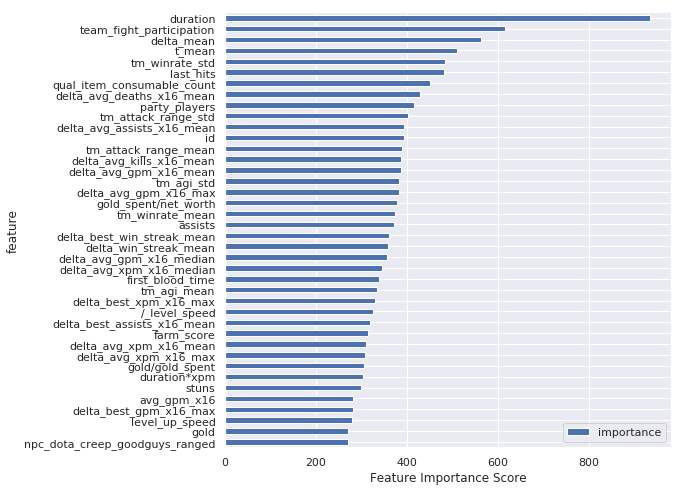

In [65]:
a = print_f_imp(clf_3, 40)

xgb
------
v1 - 0.7761393288427696<br/>
v1 without roles - 0.7760179622549912<br>
v1 with id - 0.7768371867224952<br>
v1 with only carry and support - 0.7758965956672128<br>
v2 - 0.7778688027186116<br>
v3 - 0.7784756356575034<br>
v4 - 0.7935554341889678<br>
v5 - 0.792705868074519 <br>
v5_1 - 0.7931306511317434 <br>
v5_2 - 0.8055100430851386<br>
v5_2 log - 0.8035985193276292<br>
v5_3 - 0.811123247769889<br>
v6 - 0.8110929061229444, note: add it and heroes info and tune  <br>
v6_1 - 0.813671946113235<br>
v6_1 with f2.0 - 0.8148856119910188<br>
<hr>
lgbm
-------
v6_1 with f2.0 - 0.8198919837368772<br>
++ deltas - __0.8199223253838218__ - 0.790408 lb

#### Feature importance

In [20]:
%%time
#my_model = RandomForestClassifier(random_state=0).fit(X_train, y_train)
perm = PermutationImportance(clf_3, random_state=1).fit(X_test, y_test)

CPU times: user 12h 11min 28s, sys: 21min 42s, total: 12h 33min 11s
Wall time: 4h 39min 28s


In [24]:
eli5.show_weights(perm, feature_names = data_train.columns.tolist(), top=758)

Weight,Feature
0.0948 ± 0.0030,duration
0.0366 ± 0.0023,delta_mean
0.0365 ± 0.0028,delta_avg_gpm_x16_median
0.0320 ± 0.0025,t_mean
0.0237 ± 0.0028,last_hits
0.0228 ± 0.0010,delta_avg_gpm_x16_mean
0.0182 ± 0.0008,team_fight_participation
0.0167 ± 0.0021,qual_item_consumable_count
0.0098 ± 0.0010,delta_avg_xpm_x16_median
0.0088 ± 0.0014,duration*xpm


## Make submission

In [75]:
%%time
clf_3.fit(X, y)

CPU times: user 17min, sys: 3min 13s, total: 20min 13s
Wall time: 2min 50s


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=12,
        min_child_samples=20, min_child_weight=8, min_split_gain=0.0,
        n_estimators=1500, n_jobs=-1, num_leaves=31, objective=None,
        random_state=1, reg_alpha=9, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [76]:
pred = clf_3.predict(x_test)

In [77]:
make_submit(pred)

last:  submissions/submission5-best_win_streak.csv
